In [40]:
!pip install -qU torch torchvision --index-url https://download.pytorch.org/whl/cu116

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [41]:
!pip install -qU ultralytics

In [42]:
!yolo help


    Arguments received: ['yolo', 'help']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ['pose', 'obb', 'detect', 'classify', 'segment']
                MODE (required) is one of ['predict', 'track', 'train', 'benchmark', 'val', 'export']
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 i

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
with open('/content/drive/MyDrive/Somethings/multi-label-car-damage-detection.v2i.yolov11.zip', 'rb') as f:
  zip_data = f.read()

In [45]:
import zipfile
import io

with zipfile.ZipFile(io.BytesIO(zip_data), 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [46]:
import torch
torch.cuda.is_available()

True

In [47]:
from pathlib import Path

def check_dataset_structure(dataset_root: str):
  """Verify the expected folders exist."""
  root = Path(dataset_root)
  for split in ("train", "valid", "test"):
    imgs = root / split / "images"
    labels = root / split / "labels"
    if not imgs.exists() or not labels.exists():
      raise FileNotFoundError(f"Expected {imgs} and {labels} to exist.")
  print("Dataset structure OK.")

check_dataset_structure('/content/dataset')

Dataset structure OK.


| Model     | mAP (val 50-95) | Speed (CPU ONNX ms) | Speed (A100 / TensorRT ms) | Parameters (M) | FLOPs (B) |
|-----------|------------------|----------------------|-----------------------------|----------------|-----------|
| YOLO11n   | 39.5             | ~56.1                | ~1.5                        | 2.6            | 6.5       |
| **🌟 YOLO11s**   | **47.0**             | ~90.0                | ~2.5                        | 9.4            | 21.5      |
| YOLO11m | 51.5         | ~183.2               | ~4.7                        | 20.1           | 68.0      |
| YOLO11l   | 53.4             | ~238.6               | ~6.2                        | 25.3           | 86.9      |
| YOLO11x   | 54.7             | ~462.8               | ~11.3                       | 56.9           | 194.9     |

[YOLO11 Performance Benchmarks on COCO Dataset – Ultralytics Docs](https://docs.ultralytics.com/models/yolo11/)

In [48]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

project_name="car_damage_detection"
run_name="yolov11s_colab"

results = model.train(
    data="/content/dataset/data.yaml",
    epochs=100,
    imgsz=640,                          # 640 (standard YOLO input size)
    batch=16,                           # adjust based on Colab GPU memory (16 is safe for T4)
    device=0,                           # use GPU
    project=project,
    name=run_name
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s_colab, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

In [52]:
model = YOLO("car_damage_detection/yolov11s_colab/weights/best.pt")

metrics = model.val(
    data="/content/dataset/data.yaml",
    split="test",
    plots=True
)

print(metrics)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.9±8.0 MB/s, size: 46.1 KB)
val: Scanning /content/dataset/test/labels... 302 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 302/302 825.8it/s 0.4s
val: /content/dataset/test/images/IMG_1779_jpg.rf.f0beef333366bf04d102b8aea4ad58f1.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 62, len(boxes) = 503. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.2it/s 5.9s
                   all        302        503      0.718 

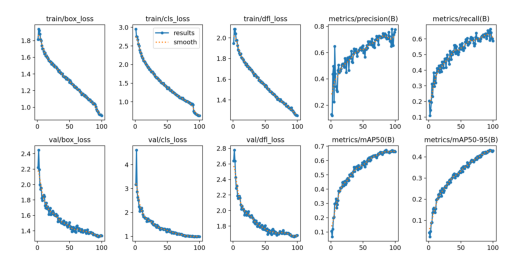

In [53]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("car_damage_detection/yolov11s_colab/results.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [57]:
import pandas as pd

csv_path = "car_damage_detection/yolov11s_colab/results.csv"

df = pd.read_csv(csv_path)

print("Final epoch results:\n")
print(df.tail(1).T)

best_map50 = df["metrics/mAP50(B)"].max()
best_epoch = df["metrics/mAP50(B)"].idxmax()
print(f"\nBest mAP@50 = {best_map50:.3f} at epoch {best_epoch}")

Final epoch results:

                               99
epoch                  100.000000
time                  9667.580000
train/box_loss           0.898770
train/cls_loss           0.627430
train/dfl_loss           1.247750
metrics/precision(B)     0.775330
metrics/recall(B)        0.586630
metrics/mAP50(B)         0.662060
metrics/mAP50-95(B)      0.428550
val/box_loss             1.334950
val/cls_loss             0.987480
val/dfl_loss             1.680030
lr/pg0                   0.000025
lr/pg1                   0.000025
lr/pg2                   0.000025

Best mAP@50 = 0.673 at epoch 85


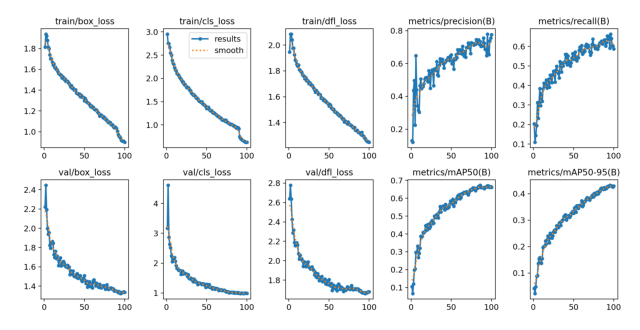

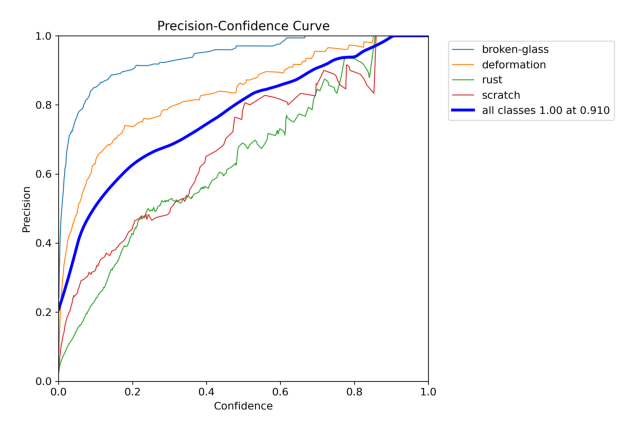

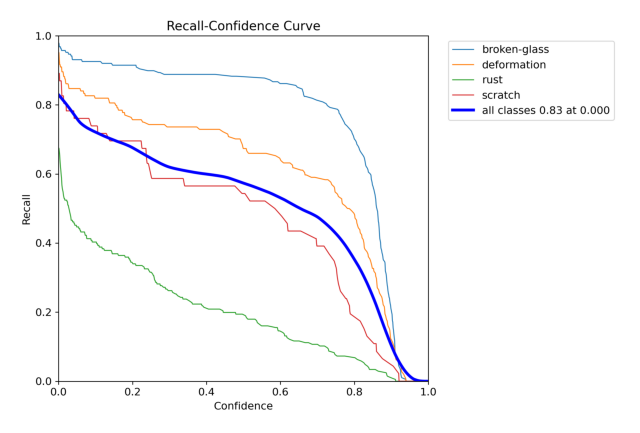

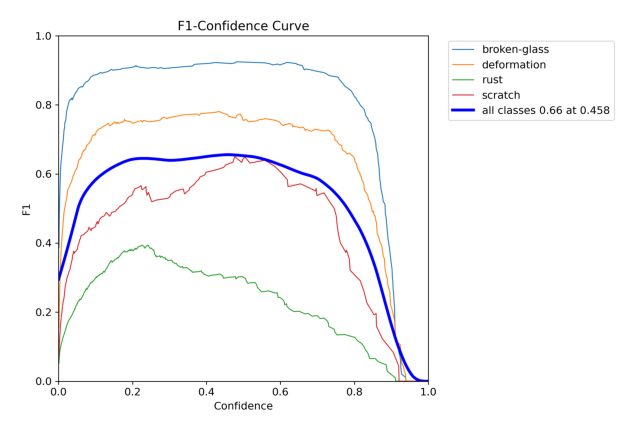

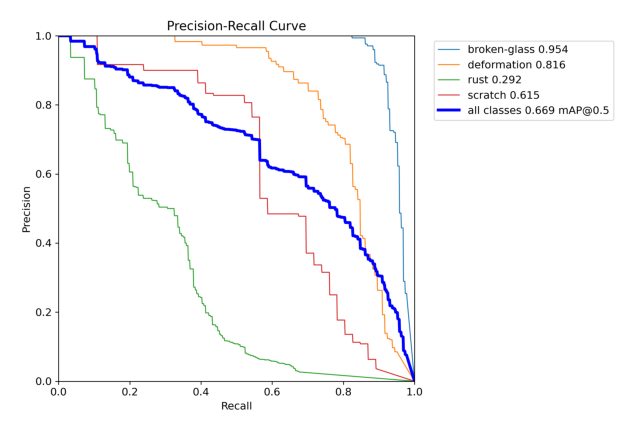

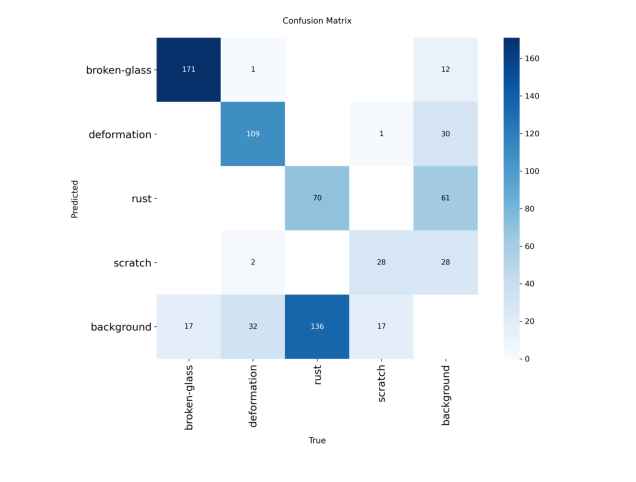

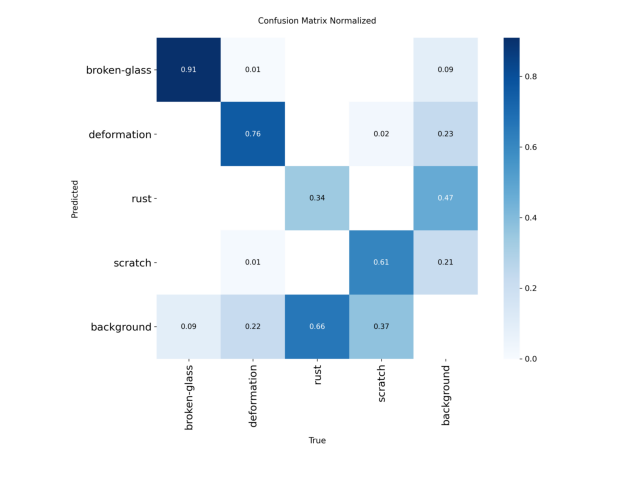

In [ ]:
import matplotlib.pyplot as plt
import os

run_dir = "car_damage_detection/yolov11s_colab"

plots = {
    "results.png": "Training curves (loss, precision, recall, mAP)",
    "BoxP_curve.png": "Precision vs Confidence",
    "BoxR_curve.png": "Recall vs Confidence",
    "BoxF1_curve.png": "F1-score vs Confidence (balance of P & R)",
    "BoxPR_curve.png": "Precision-Recall curve",
    "confusion_matrix.png": "Confusion Matrix (raw counts)",
    "confusion_matrix_normalized.png": "Confusion Matrix (normalized %)"
}

for fname, desc in plots.items():
    fpath = os.path.join(run_dir, fname)
    if os.path.exists(fpath):
        img = plt.imread(fpath)
        plt.figure(figsize=(8, 6))
        plt.title(desc)
        plt.imshow(img)
        plt.axis("off")
        plt.show()